We will now use the simple single qubit variational form to solve a problem similar to ground state energy estimation. Specifically, given a random probability vector, we want to determine a parameterization for our single qubit variational form that outputs a probability distribution close to (where closeness is the Manhattan distance between the two probability vectors).

In [1]:


# pylint: disable=missing-function-docstring
import numpy as np

np.random.seed(999999)
p0 = np.random.random()
target_distr = {0: p0, 1: 1 - p0}



create a function that takes the parameters of our single U3 variational form as arguments and returns the corresponding quantum circuit

$$ 
U3(\theta, \phi, \lambda) =
\begin{bmatrix}
\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\
e^{i\phi}\sin(\frac{\theta}{2}) & e^{i(\phi+\lambda)}\cos(\frac{\theta}{2})
\end{bmatrix}
$$

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter

params = [Parameter("theta"), Parameter("phi"), Parameter("lam")]


def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name="c")
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc


qc = get_var_form(params)

Now we specify the objective function which takes as input a list of the variational form's parameters, and returns the cost associated with those parameters

In [3]:
from qiskit_aer.primitives import Sampler, Estimator

sampler = Sampler()


def objective_function(params):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Simulate the circuit instance with paramters
    result = sampler.run(circuits=qc, parameter_values=params).result()
    # Get the quasi distribution for each measured state
    output_distr = result.quasi_dists[0]
    # Calculate the cost as the distance between the output
    # distribution and the target distribution
    cost = sum(
        abs(target_distr.get(i, 0) - output_distr.get(i, 0))
        for i in range(2**qc.num_qubits)
    )
    return cost

In [4]:
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA

optimizer = COBYLA(maxiter=500, tol=0.0001)
# Create the initial parameters (noting that our
# single qubit variational form has 3 parameters)
initial_point = np.random.rand(3)

result = optimizer.minimize(fun=objective_function, x0=initial_point)

# Obtain the output distribution using the final parameters
output_distr = (
    sampler.run(circuits=qc, parameter_values=result.x)
    .result()
    .quasi_dists[0]
)

print("Parameters Found:", result.x)
print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Cost:", objective_function(result.x))

Parameters Found: [0.30696061 0.71988065 1.96096675]
Target Distribution: {0: 0.308979188922057, 1: 0.691020811077943}
Obtained Distribution: {0: 0.3037109375, 1: 0.6962890625}
Cost: 0.053916622155885996


/tmp/ipykernel_453234/603783229.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA


linear entanglement:


/home/riccardo/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


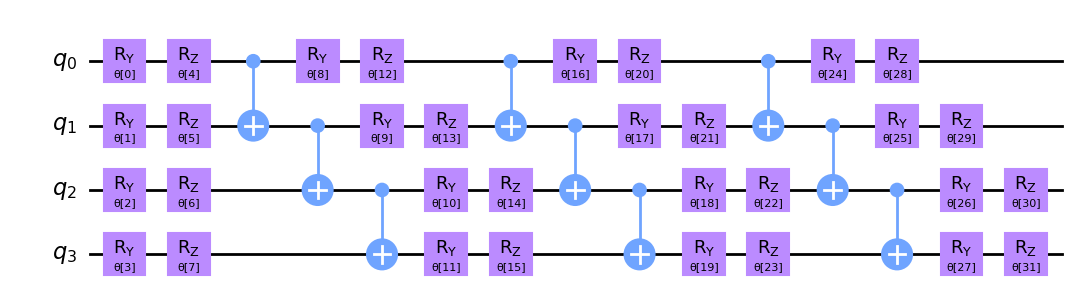

full entanglement:


/home/riccardo/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


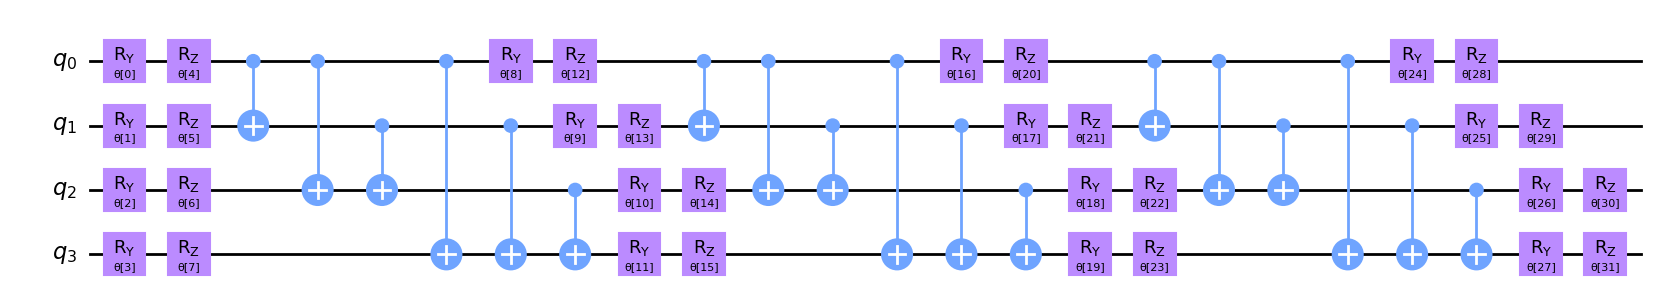

In [5]:
from qiskit.circuit.library import EfficientSU2

entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement)
    print(f"{entanglement} entanglement:")
    # We initialize all parameters to 0 for this demonstration
    display(form.decompose().draw("mpl", fold=-1))

In [6]:
# pylint: disable=line-too-long
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

qiskit_nature.settings.use_pauli_sum_op = False  # pylint: disable=undefined-variable
# pylint: enable=line-too-long
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2

Running VQE on a noisy Simulator

In [7]:
molecule = MoleculeInfo(
    # Coordinates in Angstrom
    symbols=["H", "H"],
    coords=([0.0, 0.0, -0.3625], [0.0, 0.0, 0.3625]),
    multiplicity=1,
    charge=0,
)

driver = PySCFDriver.from_molecule(molecule)
problem = driver.run()

second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

mapper = ParityMapper(num_particles=num_particles)  # Set Mapper

hamiltonian = second_q_ops[0]  # Set Hamiltonian

# Do two qubit reduction
qubit_op = mapper.map(hamiltonian)

/home/riccardo/.venv/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Now, we load a device coupling map and noise model from the IBM Quantum provider and create a quantum instance:

In [8]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored
# in Qiskit Terra, and are useful for extracting realistic noise models.

device = FakeVigo()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
noisy_estimator = Estimator(
    backend_options={"coupling_map": coupling_map, "noise_model": noise_model}
)

First, the exact ground state energy is calculated using the qubit operator and a classical exact eigensolver. Subsequently, the initial state is created, which the VQE instance uses to produce the final ansatz
. The exact result and the VQE result at each interatomic distance is stored.

In [9]:
from qiskit_aer.primitives import Estimator


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
result = exact_solver(qubit_op, problem)
exact_energies.append(result.total_energies)
print("Exact Result:", result.total_energies)
optimizer = SPSA(maxiter=100)
var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
vqe = VQE(noisy_estimator, var_form, optimizer)
vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result = problem.interpret(vqe_calc).total_energies
print("VQE Result:", vqe_result)

Exact Result: [-1.13722138]
VQE Result: [-1.04897159]


UCCSD

In [10]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    molecule.basis = {'H': 'sto-3g', 'H': 'sto-3gg'}

    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

from qiskit_aer.primitives import Estimator


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.1, 2.0, 0.01)
exact_energies = []
vqe_energies_sto_3g = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noisy_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_sto_3g.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 4.80877 Exact Energy: 2.70996
Interatomic Distance: 0.11 VQE Result: 4.45820 Exact Energy: 2.23606
Interatomic Distance: 0.12 VQE Result: 2.80276 Exact Energy: 1.84290
Interatomic Distance: 0.13 VQE Result: 3.19662 Exact Energy: 1.51195
Interatomic Distance: 0.14 VQE Result: 3.38687 Exact Energy: 1.22996
Interatomic Distance: 0.15 VQE Result: 3.97460 Exact Energy: 0.98722
Interatomic Distance: 0.16 VQE Result: 2.47670 Exact Energy: 0.77642
Interatomic Distance: 0.17 VQE Result: 3.03051 Exact Energy: 0.59196
Interatomic Distance: 0.18 VQE Result: 2.16523 Exact Energy: 0.42950
Interatomic Distance: 0.19 VQE Result: 2.61273 Exact Energy: 0.28560
Interatomic Distance: 0.2 VQE Result: 2.07404 Exact Energy: 0.15748
Interatomic Distance: 0.21 VQE Result: 2.68232 Exact Energy: 0.04291
Interatomic Distance: 0.22 VQE Result: 2.16756 Exact Energy: -0.05994
Interatomic Distance: 0.23 VQE Result: 2.39376 Exact Energy: -0.15261
Interatomic Distance: 0.24 VQE Res

In [11]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    molecule.basis = {'H': 'sto-6g', 'H': 'sto-6g'}
        
    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

from qiskit_aer.primitives import Estimator


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.1, 2.0, 0.01)
exact_energies = []
vqe_energies_sto_6g = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noisy_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_sto_6g.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 5.96055 Exact Energy: 2.70996
Interatomic Distance: 0.11 VQE Result: 4.98934 Exact Energy: 2.23606
Interatomic Distance: 0.12 VQE Result: 4.04388 Exact Energy: 1.84290
Interatomic Distance: 0.13 VQE Result: 3.51170 Exact Energy: 1.51195
Interatomic Distance: 0.14 VQE Result: 3.82797 Exact Energy: 1.22996
Interatomic Distance: 0.15 VQE Result: 1.98123 Exact Energy: 0.98722
Interatomic Distance: 0.16 VQE Result: 3.07957 Exact Energy: 0.77642
Interatomic Distance: 0.17 VQE Result: 3.15522 Exact Energy: 0.59196
Interatomic Distance: 0.18 VQE Result: 1.67342 Exact Energy: 0.42950
Interatomic Distance: 0.19 VQE Result: 1.91238 Exact Energy: 0.28560
Interatomic Distance: 0.2 VQE Result: 2.21544 Exact Energy: 0.15748
Interatomic Distance: 0.21 VQE Result: 3.18599 Exact Energy: 0.04291
Interatomic Distance: 0.22 VQE Result: 2.51380 Exact Energy: -0.05994
Interatomic Distance: 0.23 VQE Result: 1.22895 Exact Energy: -0.15261
Interatomic Distance: 0.24 VQE Res

In [12]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    molecule.basis = {'H': 'sto-3g*', 'H': 'sto-3g*'}
    
    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

from qiskit_aer.primitives import Estimator


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.1, 2.0, 0.01)
exact_energies = []
vqe_energies_sto_3gp = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noisy_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_sto_3gp.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 4.72475 Exact Energy: 2.70996
Interatomic Distance: 0.11 VQE Result: 3.25577 Exact Energy: 2.23606
Interatomic Distance: 0.12 VQE Result: 4.31706 Exact Energy: 1.84290
Interatomic Distance: 0.13 VQE Result: 3.38700 Exact Energy: 1.51195
Interatomic Distance: 0.14 VQE Result: 3.31926 Exact Energy: 1.22996
Interatomic Distance: 0.15 VQE Result: 2.83457 Exact Energy: 0.98722
Interatomic Distance: 0.16 VQE Result: 1.56068 Exact Energy: 0.77642
Interatomic Distance: 0.17 VQE Result: 1.78109 Exact Energy: 0.59196
Interatomic Distance: 0.18 VQE Result: 1.80192 Exact Energy: 0.42950
Interatomic Distance: 0.19 VQE Result: 1.12889 Exact Energy: 0.28560
Interatomic Distance: 0.2 VQE Result: 2.13880 Exact Energy: 0.15748
Interatomic Distance: 0.21 VQE Result: 2.33658 Exact Energy: 0.04291
Interatomic Distance: 0.22 VQE Result: 2.43662 Exact Energy: -0.05994
Interatomic Distance: 0.23 VQE Result: 1.03021 Exact Energy: -0.15261
Interatomic Distance: 0.24 VQE Res

In [13]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    molecule.basis = {'H': '3-21g', 'H': '3-21g'}
    
    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

from qiskit_aer.primitives import Estimator


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.1, 2.0, 0.01)
exact_energies = []
vqe_energies_3_21G = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noisy_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_3_21G.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 3.32702 Exact Energy: 2.70996
Interatomic Distance: 0.11 VQE Result: 3.97676 Exact Energy: 2.23606
Interatomic Distance: 0.12 VQE Result: 3.10217 Exact Energy: 1.84290
Interatomic Distance: 0.13 VQE Result: 3.89657 Exact Energy: 1.51195
Interatomic Distance: 0.14 VQE Result: 2.93219 Exact Energy: 1.22996
Interatomic Distance: 0.15 VQE Result: 3.90309 Exact Energy: 0.98722
Interatomic Distance: 0.16 VQE Result: 3.16055 Exact Energy: 0.77642
Interatomic Distance: 0.17 VQE Result: 3.39080 Exact Energy: 0.59196
Interatomic Distance: 0.18 VQE Result: 3.32908 Exact Energy: 0.42950
Interatomic Distance: 0.19 VQE Result: 2.40406 Exact Energy: 0.28560
Interatomic Distance: 0.2 VQE Result: 2.62803 Exact Energy: 0.15748
Interatomic Distance: 0.21 VQE Result: 2.05654 Exact Energy: 0.04291
Interatomic Distance: 0.22 VQE Result: 2.19406 Exact Energy: -0.05994
Interatomic Distance: 0.23 VQE Result: 2.18475 Exact Energy: -0.15261
Interatomic Distance: 0.24 VQE Res

In [14]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    molecule.basis = {'H': 'cc-pVTZ', 'H': 'cc-pVTZ'}
    
    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

from qiskit_aer.primitives import Estimator


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.1, 2.0, 0.01)
exact_energies = []
vqe_energies_cc_pVTZ = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noisy_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_cc_pVTZ.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 3.68432 Exact Energy: 2.70996
Interatomic Distance: 0.11 VQE Result: 5.46905 Exact Energy: 2.23606
Interatomic Distance: 0.12 VQE Result: 3.28040 Exact Energy: 1.84290
Interatomic Distance: 0.13 VQE Result: 4.34791 Exact Energy: 1.51195
Interatomic Distance: 0.14 VQE Result: 3.34090 Exact Energy: 1.22996
Interatomic Distance: 0.15 VQE Result: 1.74443 Exact Energy: 0.98722
Interatomic Distance: 0.16 VQE Result: 1.79526 Exact Energy: 0.77642
Interatomic Distance: 0.17 VQE Result: 2.64144 Exact Energy: 0.59196
Interatomic Distance: 0.18 VQE Result: 2.28939 Exact Energy: 0.42950
Interatomic Distance: 0.19 VQE Result: 0.98609 Exact Energy: 0.28560
Interatomic Distance: 0.2 VQE Result: 2.47614 Exact Energy: 0.15748
Interatomic Distance: 0.21 VQE Result: 1.18615 Exact Energy: 0.04291
Interatomic Distance: 0.22 VQE Result: 1.31992 Exact Energy: -0.05994
Interatomic Distance: 0.23 VQE Result: 1.13011 Exact Energy: -0.15261
Interatomic Distance: 0.24 VQE Res

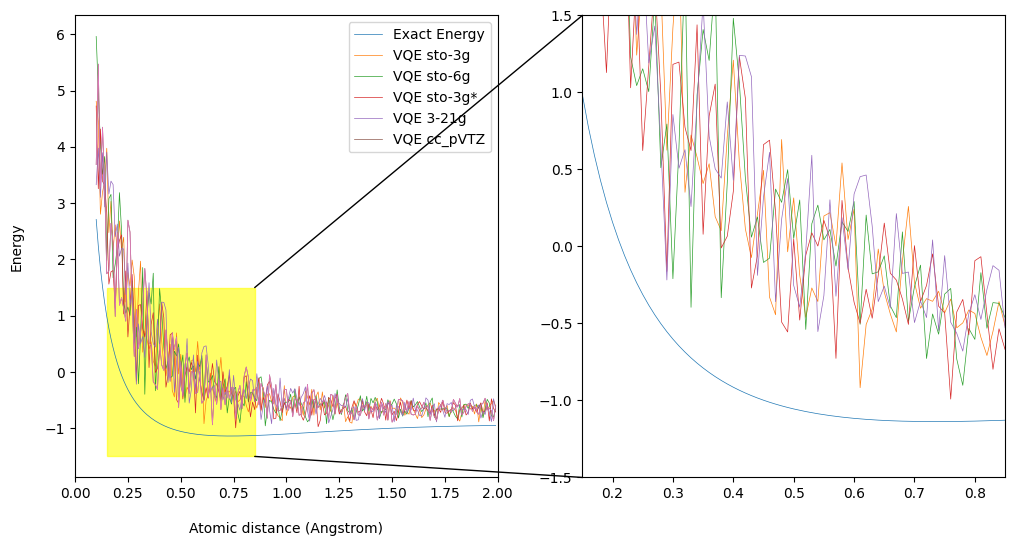

In [15]:
from matplotlib import cbook
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import pandas as pd


fig = plt.figure(figsize=(12, 6))
xmin1, xmax1, ymin1, ymax1=0,2,-2,6
xmin2, xmax2, ymin2, ymax2=0.15,0.85,-1.5,1.5

# Create first axes, the top-left plot with green plot
sub1 = fig.add_subplot(1,2,1) # two rows, two columns, fist cell
sub1.set_xlim(xmin1, xmax1)
sub1.plot(distances, exact_energies, label="Exact Energy", linewidth=0.5)
sub1.plot(distances, vqe_energies_sto_3g, label="VQE sto-3g",linewidth=0.5)
sub1.plot(distances, vqe_energies_sto_6g, label="VQE sto-6g",linewidth=0.5)
sub1.plot(distances, vqe_energies_sto_3gp, label="VQE sto-3g*",linewidth=0.5)
sub1.plot(distances, vqe_energies_3_21G, label="VQE 3-21g",linewidth=0.5)
sub1.plot(distances, vqe_energies_cc_pVTZ, label="VQE cc_pVTZ",linewidth=0.5)
sub1.set_ylabel('Energy', labelpad = 15)
sub1.set_xlabel('Atomic distance (Angstrom)', labelpad = 15)
sub1.legend()

sub2 = fig.add_subplot(1,2,2) # two rows, two columns, second cell
sub2.plot(distances, exact_energies, label="Exact Energy", linewidth=0.5)
sub2.plot(distances, vqe_energies_sto_3g, label="VQE sto-3g",linewidth=0.5)
sub2.plot(distances, vqe_energies_sto_6g, label="VQE sto-6g",linewidth=0.5)
sub2.plot(distances, vqe_energies_sto_3gp, label="VQE sto-3g*",linewidth=0.5)
sub2.plot(distances, vqe_energies_3_21G, label="VQE 3-21g",linewidth=0.5)
sub1.plot(distances, vqe_energies_cc_pVTZ, label="VQE cc_pVTZ",linewidth=0.5)
sub2.set_xlim(xmin2, xmax2)
sub2.set_ylim(ymin2, ymax2)

x_fill=[xmin2,xmin2,xmax2,xmax2]
y_fill=[ymin2,ymax2,ymax2,ymin2]
sub1.fill(x_fill,y_fill,color='yellow',alpha=0.6,label='highlight')

con1 = ConnectionPatch(xyA=(xmax2, ymin2), coordsA=sub1.transData, 
                       xyB=(xmin2, ymin2), coordsB=sub2.transData, color = 'black')
fig.add_artist(con1)
con2 = ConnectionPatch(xyA=(xmax2, ymax2), coordsA=sub1.transData, 
                       xyB=(xmin2, ymax2), coordsB=sub2.transData, color = 'black')
fig.add_artist(con2)
plt.savefig('noisyVQE_basi.png')

plt.show()